In [1]:
noExt=function(x){
return(tools::file_path_sans_ext(x))
}
bnoExt=function(x){
return(basename(tools::file_path_sans_ext(x)))
}
fNumber=function(x){
sapply(x,FUN=function(x){
strsplit(x,"__")[[1]][2]
})
}
rRider=function(x){
sapply(x,FUN=function(x){
strsplit(x,"-RIDER")[[1]][1]
})
}
# centering with 'scale()'
center_scale <- function(x) {
    scale(x, scale = FALSE)
}
#LOAD LIBRARIES 
library(gtools);
library("GenomicRanges");
options(warn=-1)
library(ggplot2)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    I, expand.grid, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb



In [2]:
#SETTING PATH 
pathRNAseq="/sharedFolder/Data/2_RNA_seq/"
results="/sharedFolder/Results/Sequencing"
previousResults="/sharedFolder/Results/Hotspot/"


In [6]:
dir.create(results,recursive=TRUE)


In [7]:
gtf=read.table(paste(previousResults,"Database_annotated.csv",sep="/"),header=TRUE,sep=",")
gtf=gtf[grep("Ligase",gtf[,6]),]
rna=read.table(paste(pathRNAseq,"/_counts.txt",sep=""),header=TRUE,row.names=1,sep="\t")
genes=c()
for(i in gtf[,8]){
genes=append(genes,strsplit(i,"_")[[1]])
}
aid=c()
for(i in genes){
if (length(grep(toupper(i),toupper(rownames(rna))))!=0){
aid=append(aid,grep(toupper(i),toupper(rownames(rna))))
}
}

In [22]:
rnaAID=rna[unique(aid),]

In [143]:
write.table(rnaAID,paste(results,"/RNA_AID_tpm.csv",sep=""),col.names=NA,sep=",")

In [144]:
rna=read.table(paste(pathRNAseq,"/_counts.txt",sep=""),header=TRUE,row.names=1,sep="\t")
rna=rna[-which(rowSums(rna)<3),]
write.table(rna,paste(results,"/RNA.csv",sep=""),col.names=NA,sep=",")

[1] "RAW"
[1] "Strongest"
[1] "Most DE"
[1] "Most DE with Threshold"


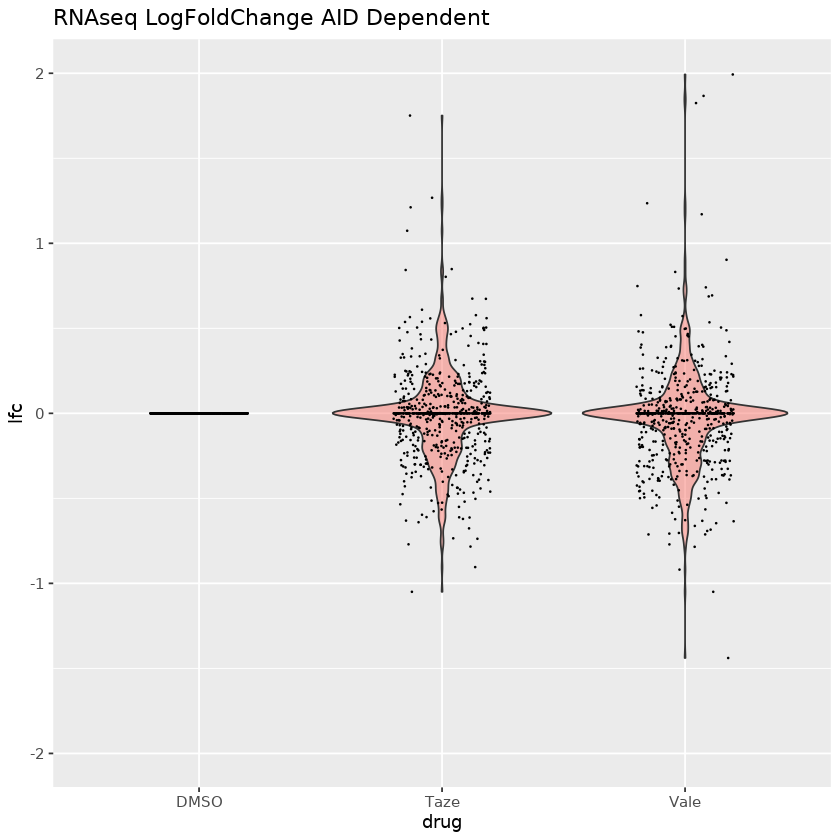

In [82]:
print("RAW")
RNAseq_newrpm=cbind(rowSums(rnaAID[,grep("DMSO",colnames(rnaAID))]),rowSums(rnaAID[,grep("TAZ",colnames(rnaAID))]),rowSums(rnaAID[,grep("Vale",colnames(rnaAID))]))

ttmp=RNAseq_newrpm[which(RNAseq_newrpm[,1]>=summary(RNAseq_newrpm[,1])[5]),]
thresholdTheBest=unique(union(names(sort(ttmp[,2]/ttmp[,1],decreasing=TRUE))[seq(1,20)],names(sort(ttmp[,3]/ttmp[,1],decreasing=TRUE))[seq(1,20)]))

foldChange=list()
geneWide=RNAseq_newrpm+0.000001
filteringTazeBS=names(sort(geneWide[,2],decreasing=TRUE))[seq(1,75)]
filteringValeBS=names(sort(geneWide[,3],decreasing=TRUE))[seq(1,75)]
filteringBS=union(filteringTazeBS,filteringValeBS)


#geneWide=geneWide[filtering,]
foldChange[[1]]=log2(geneWide[,2]/geneWide[,1])
foldChange[[2]]=log2(geneWide[,3]/geneWide[,1])


filteringTazeLFC=names(sort(foldChange[[1]],decreasing=TRUE))[seq(1,75)]
filteringValeLFC=names(sort(foldChange[[2]],decreasing=TRUE))[seq(1,75)]
filteringLFC=union(filteringTazeLFC,filteringValeLFC)

filtering=intersect(filteringBS,filteringLFC)

names(foldChange)=c("Taze","Vale")

foldChangeDF=cbind(foldChange[[1]],rep("Taze",length(foldChange[[1]])))
foldChangeDF=rbind(foldChangeDF,cbind(foldChange[[2]],rep("Vale",length(foldChange[[2]]))))
foldChangeDF=rbind(foldChangeDF,cbind(0,rep("DMSO",length(foldChange[[1]]))))
lim=max(abs(foldChange[[1]]),abs(foldChange[[2]]))

colnames(foldChangeDF)=c("lfc","drug")
foldChangeDF=data.frame(foldChangeDF,check.names=FALSE,fix.empty.names=FALSE)
foldChangeDF$lfc=as.numeric(foldChangeDF$lfc)

pp=ggplot(foldChangeDF,aes(x=drug,y=lfc,fill="red")) +
geom_violin(alpha = 0.5) +
geom_point(position = position_jitter(seed = 1, width = 0.2),size=0.1) +
theme(legend.position = "none") + ylim(-2,2) + ggtitle("RNAseq LogFoldChange AID Dependent")
plot(pp)   
print("Strongest")
tempforever=c()
for(i in filtering){
temp=unique(gtf[which(gtf[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))
}
write.table(tempforever,(paste(results,"/RNAseq_raw_strongest.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)
print("Most DE")
tempforever=c()

for(i in filteringLFC[seq(1,10)]){
temp=unique(gtf[which(gtf[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))

}
write.table(tempforever,(paste(results,"/RNAseq_raw_mostDE.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)
tempforever=c()

print("Most DE with Threshold")
for(i in thresholdTheBest){
temp=unique(gtf[which(gtf[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))
}
write.table(tempforever,(paste(results,"/RNAseq_raw_mostDETreshold.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)

[1] "filtered"
[1] "Strongest"
[1] "Most DE"
[1] "Most DE with Threshold"


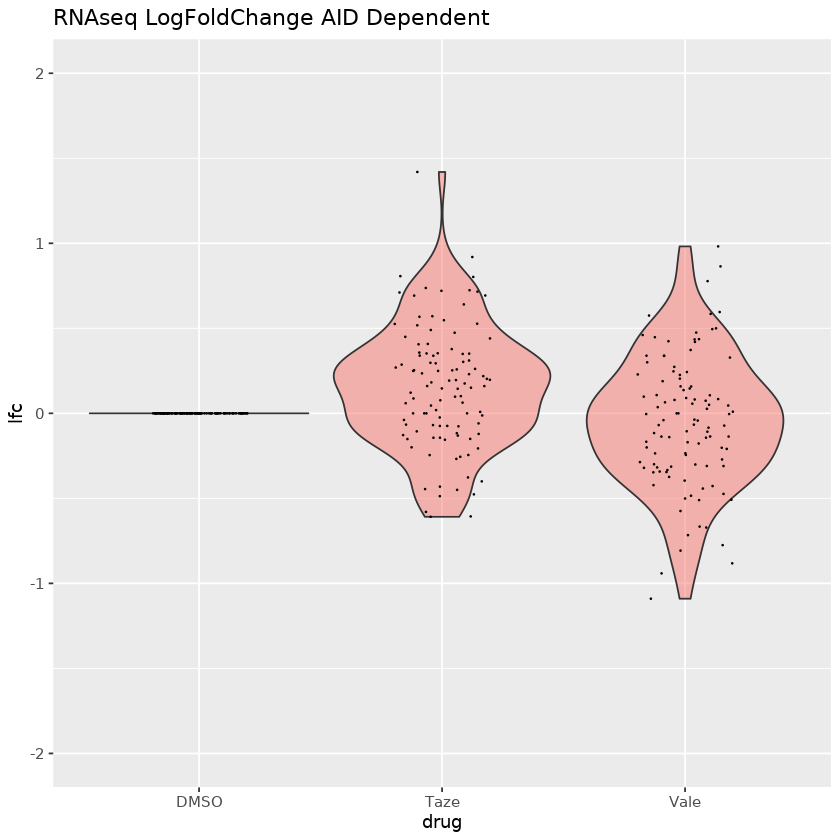

In [18]:
print("filtered")
RNAseq_newrpm=cbind(rowSums(rnaAID[,grep("DMSO",colnames(rnaAID))]),rowSums(rnaAID[,grep("TAZ",colnames(rnaAID))]),rowSums(rnaAID[,grep("Vale",colnames(rnaAID))]))
filter=unique(union(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/filtered/filtered_Lig_DMSOVale.csv",header=TRUE,row.names=1,sep=",")),rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/filtered/filtered_Lig_DMSOTaze.csv",header=TRUE,row.names=1,sep=","))))
filter=unlist(sapply(filter,FUN=function(x){toString(x)}))
filter2=c()
for(i in filter){
filter2=unique(append(filter2,unlist(sapply(gtf[which(gtf[,7]==i),8],FUN=function(x){strsplit(x,"_")}))))
}
realFilter=c()
index=1
rnaAID=rnaAID[realFilter,]
for(i in sapply(rownames(RNAseq_newrpm),FUN=function(x){toupper(strsplit(x,":")[[1]][1])})){
    if(length(intersect(i,filter2))!=0){realFilter=append(realFilter,index)}
    index=index+1
}
RNAseq_newrpm=RNAseq_newrpm[realFilter,]
write.table(log2(rnaAID+1)[realFilter,],paste(results,"/RNAseq_AID_Heatmap_RPM_FILTERED.csv",sep=""),col.names=NA,sep=",")
ttmp=RNAseq_newrpm[which(RNAseq_newrpm[,1]>=summary(RNAseq_newrpm[,1])[5]),]
thresholdTheBest=unique(union(names(sort(ttmp[,2]/ttmp[,1],decreasing=TRUE))[seq(1,20)],names(sort(ttmp[,3]/ttmp[,1],decreasing=TRUE))[seq(1,20)]))

foldChange=list()
geneWide=RNAseq_newrpm+0.000001
filteringTazeBS=names(sort(geneWide[,2],decreasing=TRUE))[seq(1,75)]
filteringValeBS=names(sort(geneWide[,3],decreasing=TRUE))[seq(1,75)]
filteringBS=union(filteringTazeBS,filteringValeBS)


#geneWide=geneWide[filtering,]
foldChange[[1]]=log2(geneWide[,2]/geneWide[,1])
foldChange[[2]]=log2(geneWide[,3]/geneWide[,1])


filteringTazeLFC=names(sort(foldChange[[1]],decreasing=TRUE))[seq(1,75)]
filteringValeLFC=names(sort(foldChange[[2]],decreasing=TRUE))[seq(1,75)]
filteringLFC=union(filteringTazeLFC,filteringValeLFC)

filtering=intersect(filteringBS,filteringLFC)

names(foldChange)=c("Taze","Vale")

foldChangeDF=cbind(foldChange[[1]],rep("Taze",length(foldChange[[1]])))
foldChangeDF=rbind(foldChangeDF,cbind(foldChange[[2]],rep("Vale",length(foldChange[[2]]))))
foldChangeDF=rbind(foldChangeDF,cbind(0,rep("DMSO",length(foldChange[[1]]))))
lim=max(abs(foldChange[[1]]),abs(foldChange[[2]]))

colnames(foldChangeDF)=c("lfc","drug")
foldChangeDF=data.frame(foldChangeDF,check.names=FALSE,fix.empty.names=FALSE)
foldChangeDF$lfc=as.numeric(foldChangeDF$lfc)

pp=ggplot(foldChangeDF,aes(x=drug,y=lfc,fill="red")) +
geom_violin(alpha = 0.5) +
geom_point(position = position_jitter(seed = 1, width = 0.2),size=0.1) +
theme(legend.position = "none") + ylim(-2,2) + ggtitle("RNAseq LogFoldChange AID Dependent")
plot(pp)   
print("Strongest")
tempforever=c()
for(i in filtering){
temp=unique(gtf[which(gtf[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))
}
write.table(tempforever,(paste(results,"/RNAseq_filtered_strongest.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)
print("Most DE")
tempforever=c()

for(i in filteringLFC[seq(1,10)]){
temp=unique(gtf[which(gtf[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))

}
write.table(tempforever,(paste(results,"/RNAseq_filtered_mostDE.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)
tempforever=c()

print("Most DE with Threshold")
for(i in thresholdTheBest){
temp=unique(gtf[which(gtf[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))
}
write.table(tempforever,(paste(results,"/RNAseq_filtered_mostDETreshold.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)

[1] "filtered"
[1] "Strongest"
[1] "Most DE"
[1] "Most DE with Threshold"


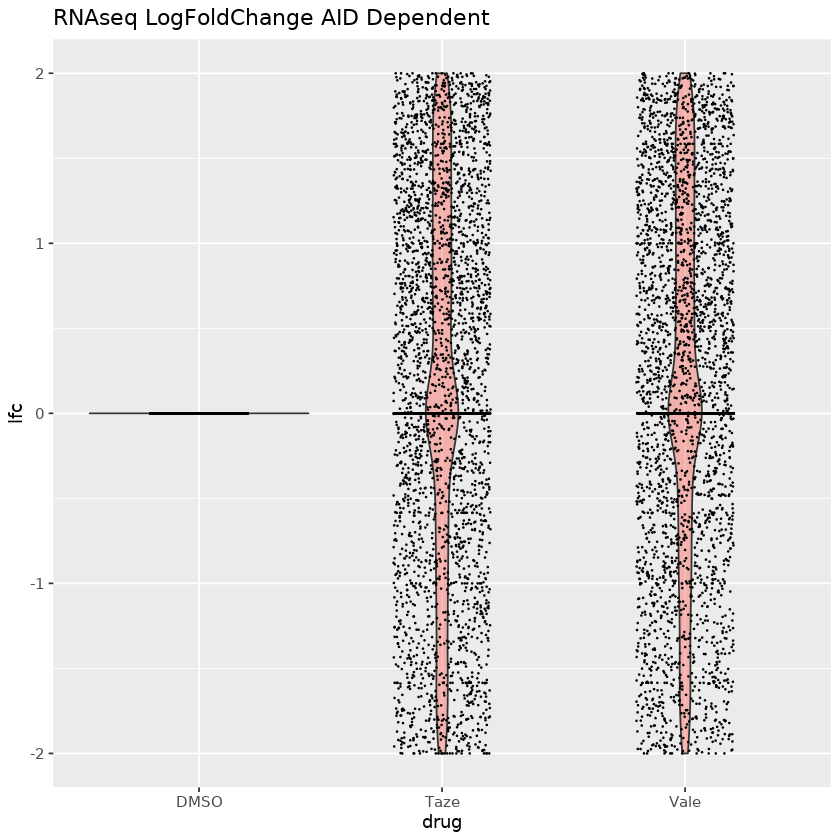

In [153]:
print("filtered")
RNAseq_newrpm=cbind(rowSums(rna[,grep("DMSO",colnames(rnaAID))]),rowSums(rnaAID[,grep("TAZ",colnames(rnaAID))]),rowSums(rnaAID[,grep("Vale",colnames(rnaAID))]))

write.table(log2(rnaAID+1)[realFilter,],paste(results,"/RNAseq_AID_Heatmap_RPM_FILTERED.csv",sep=""),col.names=NA,sep=",")
ttmp=RNAseq_newrpm[which(RNAseq_newrpm[,1]>=summary(RNAseq_newrpm[,1])[5]),]
thresholdTheBest=unique(union(names(sort(ttmp[,2]/ttmp[,1],decreasing=TRUE))[seq(1,20)],names(sort(ttmp[,3]/ttmp[,1],decreasing=TRUE))[seq(1,20)]))

foldChange=list()
geneWide=RNAseq_newrpm+0.000001
filteringTazeBS=names(sort(geneWide[,2],decreasing=TRUE))[seq(1,75)]
filteringValeBS=names(sort(geneWide[,3],decreasing=TRUE))[seq(1,75)]
filteringBS=union(filteringTazeBS,filteringValeBS)


#geneWide=geneWide[filtering,]
foldChange[[1]]=log2(geneWide[,2]/geneWide[,1])
foldChange[[2]]=log2(geneWide[,3]/geneWide[,1])


filteringTazeLFC=names(sort(foldChange[[1]],decreasing=TRUE))[seq(1,75)]
filteringValeLFC=names(sort(foldChange[[2]],decreasing=TRUE))[seq(1,75)]
filteringLFC=union(filteringTazeLFC,filteringValeLFC)

filtering=intersect(filteringBS,filteringLFC)

names(foldChange)=c("Taze","Vale")

foldChangeDF=cbind(foldChange[[1]],rep("Taze",length(foldChange[[1]])))
foldChangeDF=rbind(foldChangeDF,cbind(foldChange[[2]],rep("Vale",length(foldChange[[2]]))))
foldChangeDF=rbind(foldChangeDF,cbind(0,rep("DMSO",length(foldChange[[1]]))))
lim=max(abs(foldChange[[1]]),abs(foldChange[[2]]))

colnames(foldChangeDF)=c("lfc","drug")
foldChangeDF=data.frame(foldChangeDF,check.names=FALSE,fix.empty.names=FALSE)
foldChangeDF$lfc=as.numeric(foldChangeDF$lfc)

pp=ggplot(foldChangeDF,aes(x=drug,y=lfc,fill="red")) +
geom_violin(alpha = 0.5) +
geom_point(position = position_jitter(seed = 1, width = 0.2),size=0.1) +
theme(legend.position = "none") + ylim(-2,2) + ggtitle("RNAseq LogFoldChange AID Dependent")
plot(pp)   
print("Strongest")
tempforever=c()
for(i in filtering){
temp=unique(gtf[which(gtf[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))
}
write.table(tempforever,(paste(results,"/RNAseq_filtered_strongest.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)
print("Most DE")
tempforever=c()

for(i in filteringLFC[seq(1,10)]){
temp=unique(gtf[which(gtf[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))

}
write.table(tempforever,(paste(results,"/RNAseq_filtered_mostDE.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)
tempforever=c()

print("Most DE with Threshold")
for(i in thresholdTheBest){
temp=unique(gtf[which(gtf[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))
}
write.table(tempforever,(paste(results,"/RNAseq_filtered_mostDETreshold.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)

In [150]:
filtered2

ERROR: Error in eval(expr, envir, enclos): object 'filtered2' not found


[1] "filtered"
[1] "Strongest"
[1] "Most DE"
[1] "Most DE with Threshold"


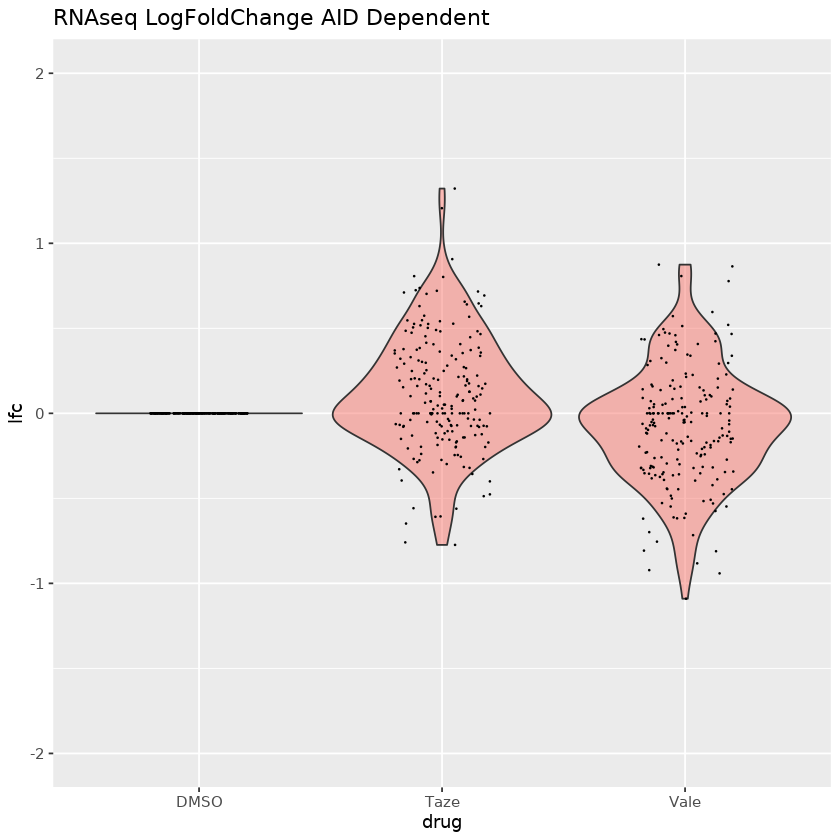

In [23]:
print("filtered")
RNAseq_newrpm=cbind(rowSums(rnaAID[,grep("DMSO",colnames(rnaAID))]),rowSums(rnaAID[,grep("TAZ",colnames(rnaAID))]),rowSums(rnaAID[,grep("Vale",colnames(rnaAID))]))
filter=unique(union(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/sortNames/_2_DMSO_TAZE.csv",header=TRUE,row.names=1,sep=",")),rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/sortNames/_5_DMSOVale.csv",header=TRUE,row.names=1,sep=","))))
filter=unlist(sapply(filter,FUN=function(x){toString(x)}))
filter2=c()
for(i in filter){
filter2=unique(append(filter2,unlist(sapply(gtf[which(gtf[,7]==i),8],FUN=function(x){strsplit(x,"_")}))))
}
realFilter=c()
index=1
#rnaAID=rnaAID[realFilter,]
for(i in sapply(rownames(RNAseq_newrpm),FUN=function(x){toupper(strsplit(x,":")[[1]][1])})){
    if(length(intersect(i,filter2))!=0){realFilter=append(realFilter,index)}
    index=index+1
}
RNAseq_newrpm=RNAseq_newrpm[realFilter,]
write.table(log2(rnaAID+1)[realFilter,],paste(results,"/RNAseq_AID_Heatmap_RPM_FILTERED.csv",sep=""),col.names=NA,sep=",")
ttmp=RNAseq_newrpm[which(RNAseq_newrpm[,1]>=summary(RNAseq_newrpm[,1])[5]),]
thresholdTheBest=unique(union(names(sort(ttmp[,2]/ttmp[,1],decreasing=TRUE))[seq(1,20)],names(sort(ttmp[,3]/ttmp[,1],decreasing=TRUE))[seq(1,20)]))

foldChange=list()
geneWide=RNAseq_newrpm+0.000001
filteringTazeBS=names(sort(geneWide[,2],decreasing=TRUE))[seq(1,75)]
filteringValeBS=names(sort(geneWide[,3],decreasing=TRUE))[seq(1,75)]
filteringBS=union(filteringTazeBS,filteringValeBS)


#geneWide=geneWide[filtering,]
foldChange[[1]]=log2(geneWide[,2]/geneWide[,1])
foldChange[[2]]=log2(geneWide[,3]/geneWide[,1])


filteringTazeLFC=names(sort(foldChange[[1]],decreasing=TRUE))[seq(1,75)]
filteringValeLFC=names(sort(foldChange[[2]],decreasing=TRUE))[seq(1,75)]
filteringLFC=union(filteringTazeLFC,filteringValeLFC)

filtering=intersect(filteringBS,filteringLFC)

names(foldChange)=c("Taze","Vale")

foldChangeDF=cbind(foldChange[[1]],rep("Taze",length(foldChange[[1]])))
foldChangeDF=rbind(foldChangeDF,cbind(foldChange[[2]],rep("Vale",length(foldChange[[2]]))))
foldChangeDF=rbind(foldChangeDF,cbind(0,rep("DMSO",length(foldChange[[1]]))))
lim=max(abs(foldChange[[1]]),abs(foldChange[[2]]))

colnames(foldChangeDF)=c("lfc","drug")
foldChangeDF=data.frame(foldChangeDF,check.names=FALSE,fix.empty.names=FALSE)
foldChangeDF$lfc=as.numeric(foldChangeDF$lfc)

pp=ggplot(foldChangeDF,aes(x=drug,y=lfc,fill="red")) +
geom_violin(alpha = 0.5) +
geom_point(position = position_jitter(seed = 1, width = 0.2),size=0.1) +
theme(legend.position = "none") + ylim(-2,2) + ggtitle("RNAseq LogFoldChange AID Dependent")
plot(pp)   
print("Strongest")
tempforever=c()
for(i in filtering){
temp=unique(gtf[which(gtf[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))
}
write.table(tempforever,(paste(results,"/RNAseq_filtered_strongest.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)
print("Most DE")
tempforever=c()

for(i in filteringLFC[seq(1,10)]){
temp=unique(gtf[which(gtf[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))

}
write.table(tempforever,(paste(results,"/RNAseq_filtered_mostDE.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)
tempforever=c()

print("Most DE with Threshold")
for(i in thresholdTheBest){
temp=unique(gtf[which(gtf[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))
}
write.table(tempforever,(paste(results,"/RNAseq_filtered_mostDETreshold.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)

In [11]:
RNAseq_newrpm

Arid5a:ENSMUSG00000037447,31062,35697,32231
Ptma:ENSMUSG00000026238,320961,359093,316950
Ptma-ps2:ENSMUSG00000084274,11,9,11
Ptma-ps1:ENSMUSG00000095331,0,0,0
Arl4c:ENSMUSG00000049866,5786,5612,5171
Phlpp1:ENSMUSG00000044340,28509,26179,22288
Zbtb18:ENSMUSG00000063659,5149,7309,6448
Traf1:ENSMUSG00000026875,14064,18017,14882
Cd82:ENSMUSG00000027215,42675,48140,43856
Cd44:ENSMUSG00000005087,46072,49692,42546
Dusp21:ENSMUSG00000025043,0,0,0
